In [1]:
import os, glob
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import fitsio
import numpy as np
import drms
import matplotlib.colors as colors
import sunpy.visualization.colormaps as cm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
aia193 = matplotlib.colormaps['sdoaia193']
os.getcwd()

'/mnt/data2/dev/AIASpikes2/notebooks'

In [3]:
client = drms.Client()
aia = client.info('aia.lev1_euv_12s')
aia.segments

,type,units,protocol,dims,note
name,,,,,
image,int,None,link via lev1,None,AIA level 1 image
spikes,int,None,link via lev1,None,Cosmic ray information


In [8]:
qstr = "aia.lev1_euv_12s[2010-07-25T18:00:12Z/1h@10m][94,131,171,193,211,304,335]{image}"
keys = [
    "T_REC",
    "T_OBS",
    "DATAMIN",
    "DATAMAX",
    "DATAMEAN",
    "DATARMS",
    "DATASKEW",
    "DATAKURT",
    "QUALITY",
    "WAVELNTH"
]
result = client.query(qstr, key=keys)

In [9]:
result = result[result.QUALITY == 0]
result

,T_REC,T_OBS,DATAMIN,DATAMAX,DATAMEAN,DATARMS,DATASKEW,DATAKURT,QUALITY,WAVELNTH
0,2010-07-25T18:00:14Z,2010-07-25T18:00:21.57Z,-23,3409,1.6088,3.46,63.26,56222.05,0,94
1,2010-07-25T18:00:14Z,2010-07-25T18:00:23.07Z,-39,2075,9.1286,15.92,8.56,239.06,0,131
2,2010-07-25T18:00:14Z,2010-07-25T18:00:25.34Z,-5,14598,234.6031,300.03,3.77,32.14,0,171
3,2010-07-25T18:00:14Z,2010-07-25T18:00:20.84Z,-10,14082,238.2837,346.52,5.04,47.03,0,193
4,2010-07-25T18:00:14Z,2010-07-25T18:00:14.07Z,-18,13172,95.5323,191.06,8.32,111.99,0,211
...,...,...,...,...,...,...,...,...,...,...
2095,2010-07-25T19:00:02Z,2010-07-25T19:00:13.34Z,-5,8570,234.5259,295.40,3.45,24.82,0,171
2096,2010-07-25T19:00:02Z,2010-07-25T19:00:08.84Z,-9,10210,237.9914,345.54,4.96,44.29,0,193
2097,2010-07-25T19:00:02Z,2010-07-25T19:00:02.07Z,-20,6084,95.4387,191.03,8.32,109.26,0,211
2098,2010-07-25T19:00:02Z,2010-07-25T19:00:03.57Z,-7,10495,65.1091,91.44,6.70,164.29,0,304


In [10]:
result = client.export(qstr, method="url", protocol='fits', email='rattie@gmu.edu')

In [12]:
result.wait()

0

In [13]:
result.download(os.path.join(os.environ['DATA'], 'SDO', 'AIA', 'images_10m'))

KeyboardInterrupt: 

In [2]:
def make_2dhist(wavelength, density=True):
    spikes_dir = os.path.join(os.environ['DATA'], 'SDO', 'AIA', 'spikes')
    sp_fits = sorted(glob.glob(os.path.join(spikes_dir, '2010', '07', '25', f'2010-07-25T18:*{wavelength:04d}.spikes.fits')))
    sp_data = [fitsio.read(f) for f in sp_fits]
    sp_data = np.concatenate(sp_data, axis=1)
    print('spikes info: ', len(sp_fits), len(sp_data), sp_data.shape)
    x = sp_data[0, ...]%4096
    y = sp_data[0, ...]//4096
    sp_data[0]
    xbinedges = np.arange(0, 4095, 35)
    ybinedges = xbinedges
    hdata, xedges, yedges = np.histogram2d(x, y, bins=(xbinedges, ybinedges), density=density)
    return hdata, xedges, yedges

In [3]:
wavel = [94,131,171,193,211,304,335]
heatmaps = {}
images_dir = os.path.join(os.environ['DATA'], 'SDO', 'AIA', 'images_10m', '2010', '07', '25')
for w in wavel:
    hist2d, x, y = make_2dhist(w, density=False)
    hist2dpdf, _, _ = make_2dhist(w, density=True)
    im_fits = sorted(glob.glob(os.path.join(images_dir, f'aia*Z.{str(w)}*.fits')))
    nim = len(im_fits)
    print(f'Nb of images for wavelength {w}: {nim}')
    aia_image, header = fitsio.read(im_fits[int(nim/2)], header=True)
    aia_image[aia_image<0] = 0
    heatmaps[str(w)] = {'hist2d':hist2d.T, 'hist2dpdf':hist2dpdf.T, 'x':x, 'y':y, 'image':aia_image, 'header':header, 'cmap':matplotlib.colormaps[f'sdoaia{w}']}

spikes info:  300 3 (3, 10584467)
spikes info:  300 3 (3, 10584467)
Nb of images for wavelength 94: 6
spikes info:  300 3 (3, 9528707)
spikes info:  300 3 (3, 9528707)
Nb of images for wavelength 131: 6
spikes info:  300 3 (3, 2606886)
spikes info:  300 3 (3, 2606886)
Nb of images for wavelength 171: 6
spikes info:  300 3 (3, 2843908)
spikes info:  300 3 (3, 2843908)
Nb of images for wavelength 193: 6
spikes info:  300 3 (3, 5273536)
spikes info:  300 3 (3, 5273536)
Nb of images for wavelength 211: 6
spikes info:  300 3 (3, 11786256)
spikes info:  300 3 (3, 11786256)
Nb of images for wavelength 304: 6
spikes info:  300 3 (3, 15026679)
spikes info:  300 3 (3, 15026679)
Nb of images for wavelength 335: 6


In [111]:
94 in wavel

True

171 linear scale


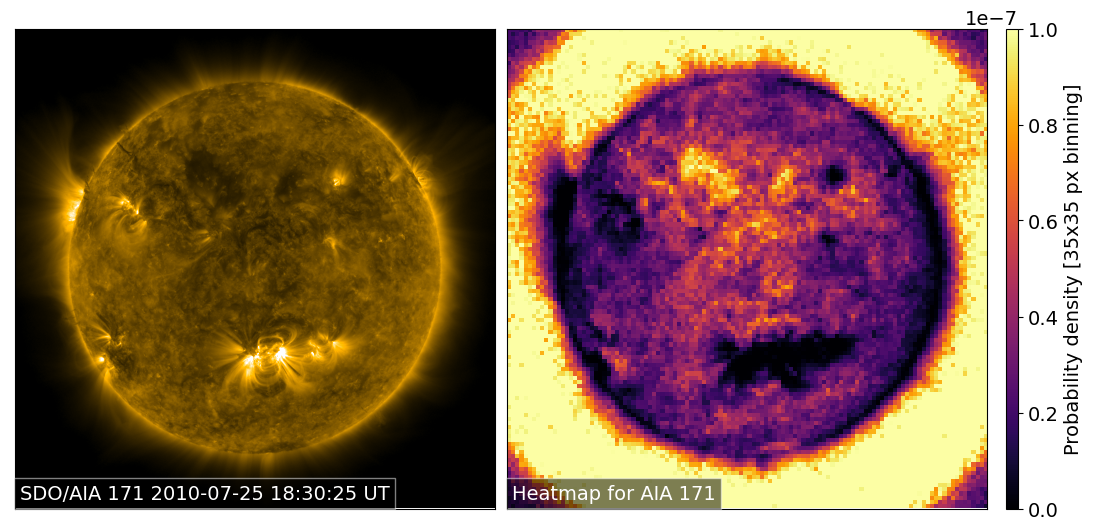

In [13]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import (MinMaxInterval, SqrtStretch,ImageNormalize)

plt.close('all')
%matplotlib inline
plt.rcParams.update({'font.size':14})
max193 = heatmaps['193']['hist2d'].max()

for w in wavel[2:3]:
    heatmap = heatmaps[str(w)]
    axs = []
    fig = plt.figure(figsize=(12, 6))
    axs.append(fig.add_axes([0.05, 0.1, 0.4, 0.8]))
    axs.append(fig.add_axes([0.46, 0.1, 0.4, 0.8]))
    if w in [94, 131, 193, 211, 304, 335]: # logarithmic colormap
        print(f'{w} log scale')
        if w == 94: 
            vmin, vmax = 0.3, 20
        elif w == 131:
            vmin, vmax = 0.7, 500
        elif w == 193:
            vmin, vmax = 20, 2500
        elif w == 211:
            vmin, vmax = 7, 1500
        elif w == 304:
            vmin, vmax = 0.8, 250
        elif w == 335:
            vmin, vmax = 0.4, 80
        else:
            vmin = 1 #np.percentile(aia_images[6], 0.01)
            vmax = np.percentile(heatmap['image'], 99.9)
        im1 = axs[0].imshow(heatmap['image']/heatmap['header']['EXPTIME'], origin='lower', cmap=heatmap['cmap'], norm=colors.LogNorm(vmin=vmin, vmax=vmax))
    else:
        vmin = 1 #np.percentile(aia_images[6], 0.01)
        vmax = np.percentile(heatmap['image'], 99.9)
        if w == 171:
            vmin, vmax = 1, 1800
        print(f'{w} linear scale')
        image = heatmap['image']/heatmap['header']['EXPTIME']
        image = image - 5
        image[image < 0.1] = 0.1
        image = np.sqrt(image)
        norm = ImageNormalize(image, vmin=vmin, vmax=vmax, stretch=SqrtStretch())
#         im1 = axs[0].imshow(image, origin='lower', cmap=heatmap['cmap'], norm=norm)
        im1 = axs[0].imshow(image, vmin=1, vmax=40, origin='lower', cmap=heatmap['cmap'])
    txt1 = axs[0].text(40, 80, f"SDO/AIA {w} {heatmap['header']['T_OBS'][:-4].replace('T', ' ')} UT", color='white')
    txt1.set_bbox(dict(facecolor='black', alpha=0.5, edgecolor='white'))
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    # # fig.colorbar(im1, ax=axs[0])

    pdfhvmin = 0
    pdfhvmax = 1e-7
    
    im2 = axs[1].imshow(heatmap['hist2dpdf'], origin='lower', cmap='inferno', vmin=pdfhvmin, vmax=pdfhvmax, extent=[0, 4095, 0, 4095])
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    txt2 = axs[1].text(40, 80, f'Heatmap for AIA {w}', color='white')
    txt2.set_bbox(dict(facecolor='black', alpha=0.5, edgecolor='white'))
    axins = axs[1].inset_axes([1.04, 0, 0.025, 1.0])
    cb1 = fig.colorbar(im2, ax=axs[1], cax=axins, label='Probability density [35x35 px binning]')
    # plt.tight_layout()
    plt.savefig(f'spikes_heatmap_{w}_prob.png')
#     plt.close('all')


In [138]:
heatmap['x']

array([   0,   35,   70,  105,  140,  175,  210,  245,  280,  315,  350,
        385,  420,  455,  490,  525,  560,  595,  630,  665,  700,  735,
        770,  805,  840,  875,  910,  945,  980, 1015, 1050, 1085, 1120,
       1155, 1190, 1225, 1260, 1295, 1330, 1365, 1400, 1435, 1470, 1505,
       1540, 1575, 1610, 1645, 1680, 1715, 1750, 1785, 1820, 1855, 1890,
       1925, 1960, 1995, 2030, 2065, 2100, 2135, 2170, 2205, 2240, 2275,
       2310, 2345, 2380, 2415, 2450, 2485, 2520, 2555, 2590, 2625, 2660,
       2695, 2730, 2765, 2800, 2835, 2870, 2905, 2940, 2975, 3010, 3045,
       3080, 3115, 3150, 3185, 3220, 3255, 3290, 3325, 3360, 3395, 3430,
       3465, 3500, 3535, 3570, 3605, 3640, 3675, 3710, 3745, 3780, 3815,
       3850, 3885, 3920, 3955, 3990, 4025, 4060])

In [135]:
35 * 117

4095

In [36]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline
plt.rcParams.update({'font.size':14})
max193 = heatmaps['193']['hist2d'].max()

for w in wavel:
    heatmap = heatmaps[str(w)]
    vmin = 1 #np.percentile(aia_images[6], 0.01)
    vmax = np.percentile(heatmap['image'], 99.8)
    axs = []
    fig = plt.figure(figsize=(12, 6))
    axs.append(fig.add_axes([0.05, 0.1, 0.4, 0.8]))
    axs.append(fig.add_axes([0.46, 0.1, 0.4, 0.8]))
    im1 = axs[0].imshow(heatmap['image'], origin='lower', cmap=heatmap['cmap'], norm=colors.LogNorm(vmin=vmin, vmax=vmax))
    txt1 = axs[0].text(40, 80, f"SDO/AIA {w} {heatmap['header']['T_OBS'][:-4].replace('T', ' ')} UT", color='white')
    txt1.set_bbox(dict(facecolor='black', alpha=0.5, edgecolor='white'))
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    # # fig.colorbar(im1, ax=axs[0])

    pdfhvmin = 0
    pdfhvmax = 1e-7
    
    im2 = axs[1].imshow(heatmap['hist2dpdf'], origin='lower', cmap='inferno', vmin=pdfhvmin, vmax=pdfhvmax, extent=[0, 4095, 0, 4095])
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    txt2 = axs[1].text(40, 80, f'Heatmap for AIA {w}', color='white')
    txt2.set_bbox(dict(facecolor='black', alpha=0.5, edgecolor='white'))
    axins = axs[1].inset_axes([1.04, 0, 0.025, 1.0])
    cb1 = fig.colorbar(im2, ax=axs[1], cax=axins, label='Probability density [40 x 40 binning]')
    # plt.tight_layout()
    plt.savefig(f'spikes_heatmap_{w}.png')
#     plt.close('all')